### Part 1 - Introduction

**Executive Summary**

Bike sharing is an innovative approach to urban mobility which combines the convenience and flexibility of a bicycle with the accessibility of public transportation. Membership enrollments, rentals and returns are automated via a network of kiosk self serve kiosks. Bikes can be rented from one location and returned to a different location as needed.

This dataset counts hourly bike rentals throughout a city over the course of 2 years. It contains around 10,000 samples that logs information about the weather at that point in time, as well as the date. It's meant to be a lightweight time series that gives people practice with encoding time based variables, but with limited the messiness.

**Objectives**

Success in analyzing this dataset heavily relies on capturing the passage of time. This dataset is primarily about being able to accurately capture the impact of time on your target variable. How do time based characteristics like time of day and previously occurring trends impact the ability to forecast total rentals? What about weather?

In [ ]:
### step 1 - importing libraries
import pandas as pd
import numpy as np
from scipy import stats
import calendar
from datetime import datetime
!pip install category_encoders
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor

# visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
### step 2 - import our data with some initial formatting
# creating custom headers, sorting values by DateTime, dropping repetitive features
headers = ['DateTime', 'Season', 'Holiday', 'WorkingDay', 'Weather', 'Temp', 'aTemp', 'Humidity', 'WindSpeed', 'Count']
df = pd.DataFrame(pd.read_csv('/content/bikeshare.csv', skiprows = 1, names = headers))
df.sort_values('DateTime', ascending = True, inplace=True)
df.drop('aTemp', inplace=True, axis=1) 

### Part 2 - Data Preparation

Feature Engineering

Features are individual independent variables that act as an input in our machine learning model(s). For a feature to be useful, it must hold a relationship with the predicted target that our model is able to understand. For example, when building a linear model, the goal is to transform raw data into features that hold linear relationships with the predicted target. In doing so, we accomplish the following.

Improve our model's predictive performance
Reduce computational needs
Improve interpretability

In [5]:
### step 1 - engineering a few time specific features
df["Date"] = df['DateTime'].apply(lambda x : x.split()[0])
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month_name()
df['DayOfWeek'] = df['Date'].dt.day_name()
df['Hour'] = df['DateTime'].apply(lambda x: int(x.split()[1].split(':')[0]))
df['DateTime']= pd.to_datetime(df['DateTime'])

In [6]:
### step 2 - ride count from previous hour
df['PreviousHour'] = df['PreviousHour'] = df['Count'].shift().values
df['PreviousHour'] = df['PreviousHour'].bfill()

### step 3 - ride count moving averages (3hrs and 24hrs)
df['3HourMovingAvg'] = round(df.rolling('3H', on='DateTime', min_periods=2)['Count'].mean().shift(),2).values
df['3HourMovingAvg'] = df['3HourMovingAvg'].bfill()
df['24HourMovingAvg']  = df.rolling('24H', on='DateTime', min_periods=2)['Count'].mean().shift().values
df['24HourMovingAvg'] = df['24HourMovingAvg'].bfill()

In [ ]:
### step 4 - intuitive helper features
df['PeakHours'] = df[['Hour', 'WorkingDay']].apply(lambda x: (0, 1)[(x['WorkingDay'] == 1 and (x['Hour'] == 8 or 17 <= x['Hour'] <= 18 or 12 <= x['Hour'] <= 13)) or (x['WorkingDay'] == 0 and  10 <= x['Hour'] <= 19)], axis = 1)
df['IdealCondtions'] = df[['Temp', 'WindSpeed']].apply(lambda x: (0, 1)[x['Temp'] > 27 and x['WindSpeed'] < 30], axis = 1)

In [10]:
### step 5 - final product 
df.head(3)

,DateTime,Season,Holiday,WorkingDay,Weather,Temp,Humidity,WindSpeed,Count,Date,Year,Month,DayOfWeek,Hour,PreviousHour,3HourMovingAvg,24HourMovingAvg,PeakHours,IdealCondtions
0,2011-01-01 00:00:00,Spring,0,0,Clear Skies,9.84,81,0.0,16,2011-01-01,2011,January,Saturday,0,16.0,28.0,28.0,0,0
1,2011-01-01 01:00:00,Spring,0,0,Clear Skies,9.02,80,0.0,40,2011-01-01,2011,January,Saturday,1,16.0,28.0,28.0,0,0
2,2011-01-01 02:00:00,Spring,0,0,Clear Skies,9.02,80,0.0,32,2011-01-01,2011,January,Saturday,2,40.0,28.0,28.0,0,0


### Part 2 - Data Visualization

Can we identify key patterns, relationships and or anamolies within our dataset? Ideally, these analyses should be used to develop and or re-shape our initial hypothesis and improve our predictive modeling process.

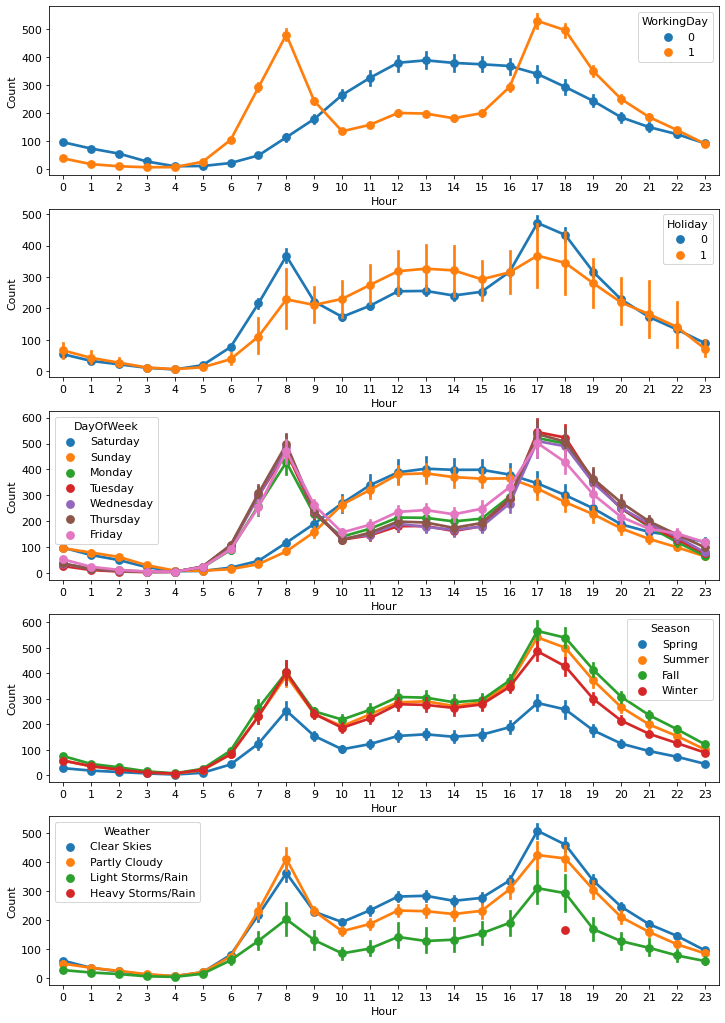

In [11]:
### step 1 - average rentals per hour by workingday, holiday, weekday, season, weather

# preparing hour
mpl.rc('font', size=11)
figure, axes = plt.subplots(nrows=5)
figure.set_size_inches(12, 18)

# assign subplot
sns.pointplot(x='Hour', y='Count', data = df, hue='WorkingDay', ax=axes[0])
sns.pointplot(x='Hour', y='Count', data = df, hue='Holiday', ax=axes[1])
sns.pointplot(x='Hour', y='Count', data = df, hue ='DayOfWeek', ax=axes[2])
sns.pointplot(x='Hour', y='Count', data = df, hue='Season', ax=axes[3])
sns.pointplot(x='Hour', y='Count', data = df, hue='Weather', ax=axes[4]);

### Part 3 - Model Development

In [12]:
### step 1 - confirming that our data is sorted by date in asceding order
df.sort_values('DateTime', ascending=True, inplace=True) 

In [13]:
### step 2 - defining a function which will create training, validation and testing datasets
def train_val_test(dataset):
    
    # get the total row count
    observations = dataset.shape[0]

    # dropping datetime features
    dataset.drop(['DateTime', 'Date'], inplace = True, axis = 1)
    
    # split the dataset into training, validation, and test
    training = dataset.iloc[ : int(observations * 0.6), : ]           
    validation = dataset.iloc[int(observations * 0.6) : int(observations * 0.8), : ]
    test = dataset.iloc[int(observations * 0.8) : , : ]

    # training
    X_training = training.drop(columns = 'Count')
    y_training = training['Count']

    # validation
    X_validation = validation.drop(columns = 'Count')
    y_validation = validation['Count']
    
    # testing
    X_test = test.drop(columns = 'Count')
    y_test = test['Count']

    # returning our desired datasets
    return X_training, y_training, X_validation, y_validation, X_test, y_test

In [14]:
### step 3 - calling the above function
X_training, y_training, X_validation, y_validation, X_test, y_test = train_val_test(df)

In [15]:
### step 4 - creating a pipeline for each encoding type
OrdinalPipe = make_pipeline(ce.OrdinalEncoder(), GradientBoostingRegressor())
TargetPipe = make_pipeline(ce.TargetEncoder(), GradientBoostingRegressor())
OneHotPipe = make_pipeline(ce.OneHotEncoder(), GradientBoostingRegressor())

### step 5 - fitting each pipeline to the training dataset, scoring on the validation dataset
OrdinalScore = OrdinalPipe.fit(X_training, y_training).score(X_validation, y_validation)
TargetScore = TargetPipe.fit(X_training, y_training).score(X_validation, y_validation)
OneHotScore = OneHotPipe.fit(X_training, y_training).score(X_validation, y_validation)

### step 6 - which pipeline/method scored best?
print(f'Ordinal Score = {OrdinalScore}, Target Score = {TargetScore}, OneHotScore = {OneHotScore}')

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Ordinal Score = 0.8029386561227961, Target Score = 0.7968328402804608, OneHotScore = 0.8025228220641633


In [22]:
### step 7 - # creating a custom pipeline for specific column encoding
CustomPipe = make_pipeline(ce.OrdinalEncoder(cols=['DayOfWeek']), ce.TargetEncoder() ,GradientBoostingRegressor())
CustomPipeScore = CustomPipe.fit(X_training, y_training).score(X_validation, y_validation)
CustomPipeFeats = pd.DataFrame({'Feature': X_training.columns,'Weight': CustomPipe[2].feature_importances_}).sort_values(by='Weight', ascending=False)
print(f'Custom Pipeline Score = {CustomPipeScore}')

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Custom Pipeline Score = 0.803464266088928


In [ ]:
### step 8 - looping through multiple fitting parameters to identify the most accurate model
n_estimators  = [100, 250, 500]
learning_rate = [.05, .1, .2]
max_depth     = [3, 4, 5, 6]
cv_scores     = []

# and cycle through our model parameters
for estimators in n_estimators:
    for rate in learning_rate:
        for depth in max_depth:
            print(f"Fitting model with parameters:  n_estimators - {estimators}, learning_rate - {rate}, max_depth - {depth}")
            mod = GradientBoostingRegressor(n_estimators=estimators, learning_rate=rate, max_depth=depth, max_features=0.6)
            pipe = make_pipeline(ce.OrdinalEncoder(cols=['DayOfWeek']), ce.TargetEncoder() ,mod)
            pipe.fit(X_training, y_training)
            score = pipe.score(X_validation, y_validation)
            print(f"Out-of-sample score: {score}")
            cv_scores.append((score, estimators, rate, depth))

In [24]:
### step 9 - identifying our most reliable model paramters
max(cv_scores) 

(0.865768618084569, 100, 0.2, 4)

In [25]:
### step 10 - creating our final model using the above parameters
mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.2, max_depth=4)
TestPipe = make_pipeline(ce.OrdinalEncoder(cols=['DayOfWeek']), ce.TargetEncoder() ,mod)
TestPipe.fit(X_training, y_training).score(X_validation, y_validation)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.8356044420354819

## Summary

I wish I had more time to work on this project before submitting. I'll work on it in my own tim. In short, hourly trends are extremely important in this analysis. I'd love submit additional work I compile on this project.